In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/selfie2cartoon.zip -d /

In [3]:
import glob
faces = glob.glob('/trainA/*.jpg')
cartoons = glob.glob("/trainB/*.jpg")
faces_test = glob.glob('/testA/*.jpg')
cartoons_test = glob.glob("/testB/*.jpg")

In [3]:
path = '/Users/k15/Downloads/cartoon/'

In [4]:
import glob
faces = glob.glob(path + '../selfie2anime/trainA/*.jpg')
cartoons = glob.glob(path + "/trainB/*.png")
faces_test = glob.glob(path + '../selfie2anime/testA/*.jpg')
cartoons_test = glob.glob(path + "/testB/*.png")

In [5]:
len(faces), len(cartoons), len(faces_test), len(cartoons_test)

(3400, 194, 100, 10)

In [6]:
import cv2
for file in faces[:10]:
    img = cv2.imread(file)
    print (img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


In [7]:
# Sharpen Images to make them look like sketches
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=3.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

Human Faces


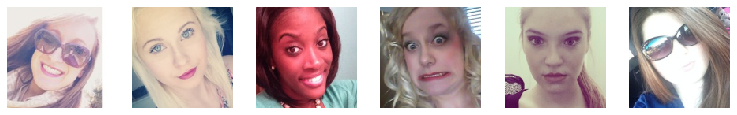

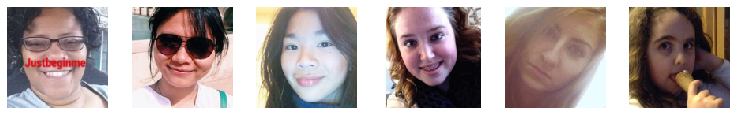

--------------------------------------------------------------------------------
cartoon Faces


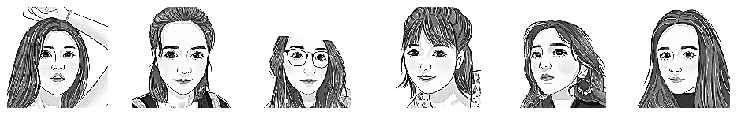

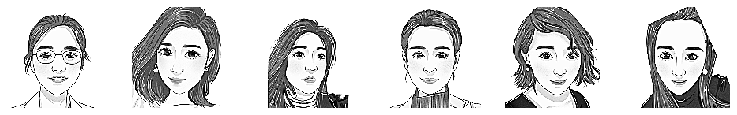

In [8]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(6):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128,128))
        plt.subplot(660 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("cartoon Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(6):
        file = np.random.choice(cartoons)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,128))
        img = unsharp_mask(img)
        plt.subplot(660 + 1 + j)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [9]:
import tensorflow_addons as tfa

In [10]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [11]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
    target_style = tensorflow.keras.layers.Input(shape=(16, 16, 512))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d5 = tensorflow.keras.layers.Concatenate()([d5, target_style])
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, target_style, translated_image

source_image, target_style, translated_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=[source_image, target_style], outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [12]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [13]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_11 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       5245

In [14]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# VGG features

In [15]:
image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block4_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 16, 16, 512)       10585152  
Total params: 10,585,152
Trainable params: 10,585,152
Non-trainable params: 0
_________________________________________________________________
None


# Customized-Face2cartoon-GAN

In [16]:
source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
target_features = tensorflow.keras.layers.Input(shape=(16, 16, 512))

# Domain Transfer
custom_vgg.trainable=False
fake_cartoon = generator_network([source_image, target_features])
  
discriminator_network.trainable=False

# Tell Real vs Fake
real_vs_fake = discriminator_network(fake_cartoon)

face2cartoon_gan = tensorflow.keras.models.Model(inputs =[source_image, target_features], outputs = [real_vs_fake, fake_cartoon, fake_cartoon])
face2cartoon_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 16, 16, 512) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  42882051    input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8, 8, 1)      2766529     model[0][0]                

# Custom Content Loss (vgg features Loss)

In [17]:
def custom_content_loss(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = custom_vgg(y_true)
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.keras.losses.mean_absolute_error(y_true_features, y_pred_features)
    return content_loss

# Compiling Models

In [18]:
face2cartoon_gan.compile(loss=['mse', custom_content_loss, custom_content_loss],\
                       optimizer=adam_optimizer, loss_weights=[1, 1, 0.1])

# Define Data Generators

In [19]:
def faces_to_cartoons(faces, styles, generator_network):
    styles = custom_vgg(styles)
    generated_samples = generator_network.predict_on_batch([faces, styles])
    return generated_samples

def do_smoothing(img):
    # taken from https://github.com/penny4860/Keras-CartoonGan/blob/master/cartoon/utils.py
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    rgb_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)

    gauss_img = np.copy(rgb_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

    return gauss_img

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=3.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    sharps = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img2 = unsharp_mask(img)
        images.append((img-127.5)/127.5)
        sharps.append((img2-127.5)/127.5)
    face_images = np.array(images)
    face_sharps = np.array(sharps)

    random_files = np.random.choice(cartoons, size=batch_size)
    images = []
    smooth_images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        smooth = do_smoothing(img)
        img = unsharp_mask(img)
        images.append((img-127.5)/127.5)
        smooth_images.append((smooth-127.5)/127.5)
    cartoon_images = np.array(images)
    cartoon_smooth_images = np.array(smooth_images)
    return face_images, face_sharps, cartoon_images, cartoon_smooth_images

def show_generator_results(generator_network):
    images = []
    styles = []
    for j in range(7):
        file = np.random.choice(faces_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

        file = np.random.choice(cartoons_test)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = unsharp_mask(img)
        styles.append(img)

    print ('Human Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Customized cartoon Version')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        style = (styles[j]-127.5)/127.5
        output = faces_to_cartoons(np.array([img]), np.array([style]), generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
        plt.imshow(output, cmap='gray')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [20]:
len(faces), len(cartoons)

(3400, 194)

Human Face Images


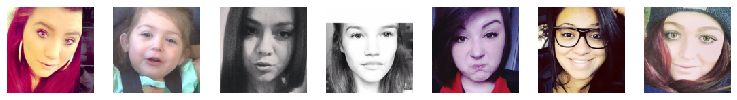

Customized cartoon Version


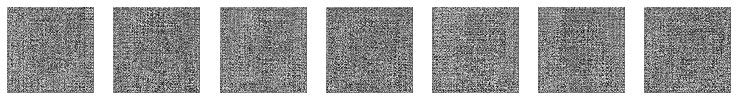

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_0/assets
Epoch:0, Step:0, D-Loss:3.889, D-Acc:50.000, G-Loss:5.162
Human Face Images


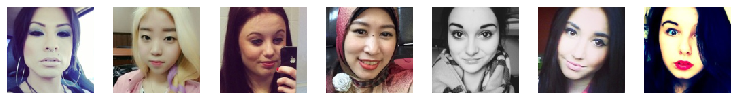

Customized cartoon Version


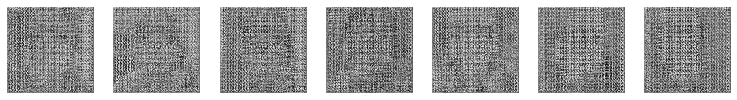

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_100/assets
Epoch:0, Step:100, D-Loss:0.313, D-Acc:59.375, G-Loss:2.611
Human Face Images


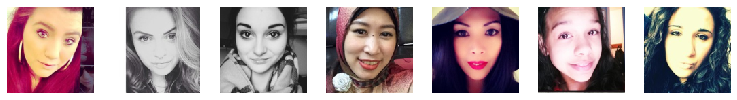

Customized cartoon Version


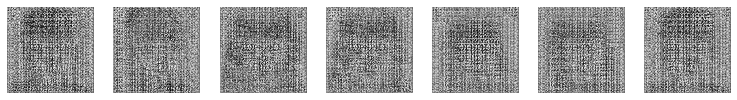

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_200/assets
Epoch:0, Step:200, D-Loss:0.233, D-Acc:71.354, G-Loss:2.492
Human Face Images


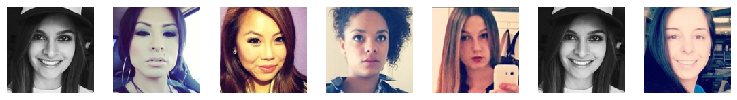

Customized cartoon Version


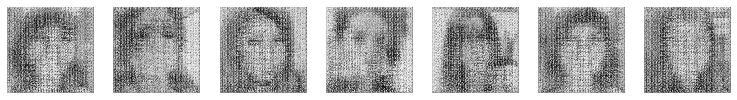

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_300/assets
Epoch:0, Step:300, D-Loss:0.221, D-Acc:75.000, G-Loss:2.620
Human Face Images


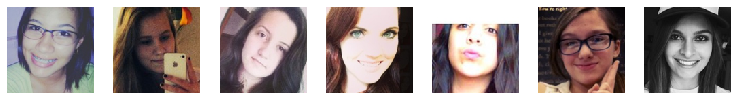

Customized cartoon Version


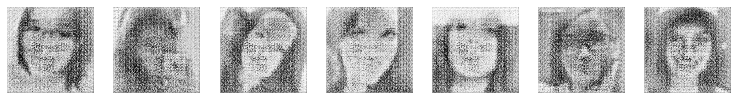

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_400/assets
Epoch:0, Step:400, D-Loss:0.178, D-Acc:74.479, G-Loss:2.870
Human Face Images


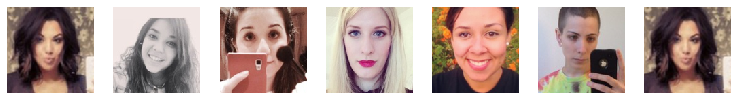

Customized cartoon Version


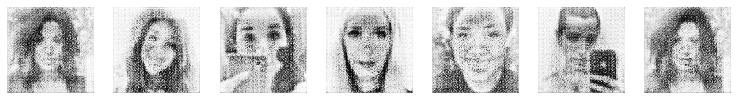

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_500/assets
Epoch:0, Step:500, D-Loss:0.105, D-Acc:86.979, G-Loss:2.721
Human Face Images


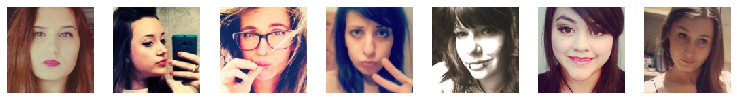

Customized cartoon Version


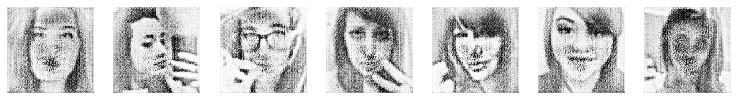

INFO:tensorflow:Assets written to: /Users/k15/Downloads/cartoonDataset/weights/sharp_mod_0_600/assets
Epoch:0, Step:600, D-Loss:0.080, D-Acc:93.229, G-Loss:2.424


In [ ]:
epochs = 500
batch_size = 1
steps = 3400

for i in range(0, epochs):
    for j in range(steps): 
        if j%100 == 0:
            show_generator_results(generator_network)
            generator_network.save("/Users/k15/Downloads/cartoonDataset/weights/sharp_mod_" + str(i) + "_" + str(j))

        human_faces, sharp_faces, cartoon_faces, smooth_cartoon_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        custom_vgg.trainable=False

        styles = custom_vgg(cartoon_faces)
        fake_cartoon_faces = generator_network([human_faces, styles])
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(cartoon_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_cartoon_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_cartoon_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = face2cartoon_gan.train_on_batch([human_faces, styles],[real_patch, sharp_faces, cartoon_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            